## Importing Necesseties

In [1]:
import re
import string
import pandas as pd
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords

from collections import Counter

from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Reading the Data

In [2]:
data = pd.read_csv('../data/sentences123456_no_but.csv')
data.head(5)

,sentence,sentiment
0,"It's a pretty good, inexpensive casual or busi...",1
1,"For example, it has no side pleats in back and...",0
2,If you do you'll be disappointed,2
3,This is only noticeable to me and only because...,0
4,"Also, there are lots of loose threads from pro...",2


## Text Preprocessing

### Cleaning the Corpus

In [3]:
'''
Make text lowercase, remove text in square brackets, remove links, remove HTML tags,
remove punctuation, remove words containing numbers, remove all single characters, 
and substitute multiple spaces with single space.
'''
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

data['sentence'] = data['sentence'].apply(lambda x:clean_text(x))

# delete row with missing values
data = data.dropna(axis=0)

data.head(5)

,sentence,sentiment
0,its pretty good inexpensive casual or business...,1
1,for example it has no side pleats in back and ...,0
2,if you do youll be disappointed,2
3,this is only noticeable to me and only because...,0
4,also there are lots of loose threads from prod...,2


### Lemmatization

In [4]:
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            yield wnl.lemmatize(word, pos='r')
        else:
            yield word

In [5]:
data['sentence'] = data['sentence'].apply(lambda x:" ".join(lemmatize_all(str(x))))
data.head(5)

,sentence,sentiment
0,its pretty good inexpensive casual or business...,1
1,for example it have no side pleat in back and ...,0
2,if you do youll be disappoint,2
3,this be only noticeable to me and only because...,0
4,also there be lot of loose thread from product...,2


### Tokenizing Data

In [6]:
data['x_temp'] = data['sentence'].apply(lambda x:str(x).split())

### Removing Stopwords

In [7]:
top = Counter([item for sublist in data['x_temp'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,4702
1,be,4513
2,shirt,4012
3,and,3375
4,fit,2519
5,it,2295
6,to,1784
7,i,1659
8,for,1561
9,this,1542


In [8]:
def remove_stopword(x):   
    return [y for y in x if y not in stopwords.words('english')]

In [9]:
data['x_temp'] = data['x_temp'].apply(lambda x:remove_stopword(x))
top = Counter([item for sublist in data['x_temp'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,shirt,4012
1,fit,2519
2,great,1247
3,good,1128
4,look,880
5,nice,787
6,quality,730
7,size,714
8,like,707
9,buy,672


### One-hot Encoding

In [10]:
def one_hot(x):
    if x == 0 or x == '0': # neutral or unknown
        x = [1, 0, 0]
    elif x == 1 or x == '1': # positive
        x = [0, 1, 0]
    elif x == 2 or x == '2': # negative
        x = [0, 0, 1]
    else:
        x = None
    return x

In [11]:
data['y_temp'] = data['sentiment'].apply(lambda x:one_hot(x))

# delete row with poorly classified sentiment
data = data.dropna(axis=0)

data.head(10)

,sentence,sentiment,x_temp,y_temp
0,its pretty good inexpensive casual or business...,1,"[pretty, good, inexpensive, casual, business, ...","[0, 1, 0]"
1,for example it have no side pleat in back and ...,0,"[example, side, pleat, back, doesnt, box, plea...","[1, 0, 0]"
2,if you do youll be disappoint,2,"[youll, disappoint]","[0, 0, 1]"
3,this be only noticeable to me and only because...,0,"[noticeable, seem, habit, mess]","[1, 0, 0]"
4,also there be lot of loose thread from product...,2,"[also, lot, loose, thread, production, arent, ...","[0, 0, 1]"
5,not big deal,0,"[big, deal]","[1, 0, 0]"
6,overall solid shirt,1,"[overall, solid, shirt]","[0, 1, 0]"
7,pardon the pun,0,"[pardon, pun]","[1, 0, 0]"
8,and great standby for any traditional guy closet,1,"[great, standby, traditional, guy, closet]","[0, 1, 0]"
9,this be one of van heusens well quality make s...,1,"[one, van, heusens, well, quality, make, shirt]","[0, 1, 0]"


### Data Splitting

In [12]:
train_data, test_data = train_test_split(data, train_size = 0.80, random_state = 0)

x_train = train_data['x_temp']
x_test = test_data['x_temp']

y_train = []
y_test = []

for i in range(len(train_data['y_temp'])):
    y_train.append(train_data['y_temp'].iloc[i])
    
for i in range(len(test_data['y_temp'])):
    y_test.append(test_data['y_temp'].iloc[i])
    
y_train = np.array(y_train) 
y_test = np.array(y_test)

### Integer Encoding

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [14]:
threshold = 3
total_cnt = len(tokenizer.word_index) # total word count
rare_cnt = 0 # number of words with frequency of occurrence below the threshold
total_freq = 0 # sum of frequencies of all word in training data
rare_freq = 0 # sum of frequency of words with frequency less than threshold

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('total word count:',total_cnt)
print('count of rare words with a frequency of %s or less.: %s'%(threshold - 1, rare_cnt))
print("proportion of rare words in a word set:", (rare_cnt / total_cnt)*100)
print("rare word frequency ratio to total frequency of occurrence:", (rare_freq / total_freq)*100)

total word count: 4027
count of rare words with a frequency of 2 or less.: 2605
proportion of rare words in a word set: 64.68835361311149
rare word frequency ratio to total frequency of occurrence: 6.841387201830824


In [15]:
# remove words with a frequency of 3 or less
# +2 considering padding token 0 and OOV token 1
vocab_size = total_cnt - rare_cnt + 2
print('size of word set:',vocab_size)

size of word set: 1424


In [16]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

print(x_train[:3])
print(x_test[:3])
print(len(x_train))

[[35, 73, 531], [2, 3], [409, 315, 1151, 16, 371]]
[[1, 199, 9, 37, 812, 9, 26, 140, 217, 14], [7, 2], [24]]
10168


In [17]:
drop_train = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]

# remove empty samples
x_train = np.delete(x_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(x_train))
print(len(y_train))

10083
10083


C:\Users\Chorom Ham\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Padding

=====Train Data=====
max length:  39
average length:  4.506991966676584

=====Test Data=====
max length:  51
average length:  4.451435312622887


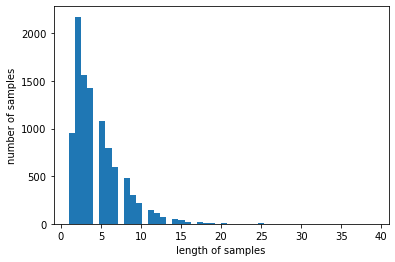

In [18]:
train_max_len = max(len(l) for l in x_train)
train_average_len = sum(map(len, x_train))/ len(x_train)
test_max_len = max(len(l) for l in x_test)
test_average_len = sum(map(len, x_test))/ len(x_test)

print("=====Train Data=====")
print("max length: ", train_max_len) 
print("average length: ", train_average_len)
print("\n=====Test Data=====")
print("max length: ", test_max_len) 
print("average length: ", test_average_len)

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    percentage = (cnt / len(nested_list))*100
    print('percentage of examples with length %s or less in the total example: %.3f'
          %(max_len,percentage))

In [20]:
max_len = 22
below_threshold_len(max_len, x_train)

percentage of examples with length 22 or less in the total example: 99.861


In [21]:
x_train = pad_sequences(x_train, maxlen=max_len) 
x_test = pad_sequences(x_test, maxlen=max_len)

## Model Development

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, 100)) 
model.add(LSTM(128)) 
model.add(Dense(3, activation='softmax'))

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [24]:
opt = optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=10, epochs=50, callbacks=[es, mc], validation_split=0.1)

Epoch 1/50
908/908 [==============================] - 18s 16ms/step - loss: 0.9988 - accuracy: 0.5331 - val_loss: 0.8436 - val_accuracy: 0.5986

Epoch 00001: val_accuracy improved from -inf to 0.59861, saving model to best_model.h5
Epoch 2/50
908/908 [==============================] - 14s 16ms/step - loss: 0.8032 - accuracy: 0.6008 - val_loss: 0.7620 - val_accuracy: 0.6591

Epoch 00002: val_accuracy improved from 0.59861 to 0.65907, saving model to best_model.h5
Epoch 3/50
908/908 [==============================] - 14s 16ms/step - loss: 0.7399 - accuracy: 0.6436 - val_loss: 0.7285 - val_accuracy: 0.6938

Epoch 00003: val_accuracy improved from 0.65907 to 0.69376, saving model to best_model.h5
Epoch 4/50
908/908 [==============================] - 14s 15ms/step - loss: 0.6894 - accuracy: 0.6889 - val_loss: 0.6971 - val_accuracy: 0.6997

Epoch 00004: val_accuracy improved from 0.69376 to 0.69970, saving model to best_model.h5
Epoch 5/50
908/908 [==============================] - 15s 16ms/

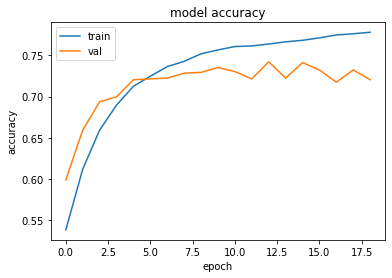

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

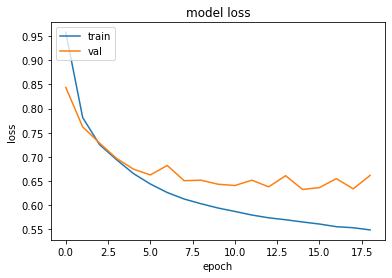

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
loaded_model = load_model('best_model.h5')
print("Test Accuracy: {:.4f}%".format(loaded_model.evaluate(x_test, y_test)[1]*100))

80/80 [==============================] - 2s 12ms/step - loss: 0.6158 - accuracy: 0.7464
Test Accuracy: 74.6363%
